In [34]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Flatten
import tensorflow as tf

import itertools
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pickle

from keras_context.switches import SwitchModel, TdErrorSwitch
from keras_context.callbacks import ContextLogger
from keras_context.layers import Context
from keras_context.models import ContextModel
from keras_context.flags import Verbosity
from keras_context.utils import set_seed

## Utility Functions

In [2]:
def skip_randint(max_value, skip):
    """
    Generate a new random integer between 0 and `max_value`.
    The returned value will not equal `skip`
    """
    value = np.random.randint(max_value - 1)
    return value if value < skip else (value + 1)

In [3]:
def distance_to_goal(state, goal, size):
    dist = state - goal
    return min((size + dist)%size, (size - dist)%size) # left vs. right

In [4]:
def q_function(model, maze_size):
    action_values = np.array([model.predict(np.hstack((np.identity(maze_size), [a]*maze_size))).flatten() for a in np.identity(2)])
    return action_values

In [5]:
def v_function(q_values):
    left, right = q_values
    s = len(left)
    value = np.zeros(s)
    for i in range(len(value)):
        value[i] = max(left[(i+1)%s], right[(i-1)%s])
    return value

In [6]:
def optimal_q_function(maze_size, goal, gamma=1.0, reward_schedule=(-1.0, 1.0)):
    opt_v = optimal_v_function(maze_size, goal, gamma, reward_schedule)
    return np.array([np.roll(opt_v, 1), np.roll(opt_v, -1)])

In [7]:
def optimal_v_function(maze_size, goal, gamma=1.0, reward_schedule=(-1.0, 1.0)):
    v = np.zeros(maze_size)
    v[0] = reward_schedule[1]
    for i in range(1, maze_size//2 + 1):
        v[-i] = v[i] = reward_schedule[0] + gamma*v[i-1]
    return np.roll(v, goal)

In [8]:
def v_loss(values, optimal_values):
    return np.mean(np.square(values, optimal_values))

In [9]:
def q_loss(q_values, optimal_q_values, goal):
    return np.mean(np.square(np.delete(q_values - optimal_q_values, goal)))

In [10]:
def skip_randint(max_value, skip):
    """
    Generate a new random integer between 0 and `max_value`.
    The returned value will not equal `skip`
    """
    value = np.random.randint(max_value - 1)
    return value if value < skip else (value + 1)

In [11]:
def distance_to_goal(state, goal, size):
    dist = state - goal
    return min((size + dist)%size, (size - dist)%size) # left vs. right

In [12]:
def suboptimal_moves(q_values, goal, size):
    subopt_moves = 0
    d = lambda state: distance_to_goal(state, goal, size)
    for state in np.delete(np.arange(size), goal):
        offset = -1 if np.argmax(q_values[:,state]) == 0 else 1
        if np.max(d(state+offset) >= d(state)):
            subopt_moves += 1
    return subopt_moves

In [13]:
def plot_v_function(values, title=None):
    fig, ax = plt.subplots()
    x = np.arange(maze_size + 1)
    ax.plot(x, np.concatenate((values, values[:1])), label="Value")
    ax.grid()
    ax.legend()
    ax.set_title(title)

In [14]:
def plot_q_function(q_values, title=None):
    fig, ax = plt.subplots()
    x = np.arange(maze_size + 1)
    for i, label in enumerate(("left", "right")):
        values = q_values[i]
        ax.plot(x, np.concatenate((values, values[:1])), label=label)
    ax.grid()
    ax.legend()
    ax.set_title(title)

In [15]:
def get_deltas(plot_log):
    key = list(plot_log.keys())[0]
    return plot_log[key][(None, 'Epoch', 'Context Delta')]['Context Delta']['y']

In [16]:
def plot(model, maze_size):
    action_values = q_function(model, maze_size)
    plot_q_function(action_values)

In [17]:
def plot_moves(moves, label="Sub-optimal Moves vs Episode"):
    fig, ax = plt.subplots()
    x = np.arange(len(moves))
    ax.plot(x, moves, label=label)
    ax.grid()
    ax.legend()

## Q-learning

In [18]:
def encode_state_action(state, action):
    return np.concatenate((state, np.identity(2)[action]))

In [19]:
def predict(model, state):
    """
    Predict the Q-values for a given state.
    The resulting predictions are ordered by action ID
    """
    inputs = np.array([np.concatenate((state, a)) for a in np.identity(2)])
    return inputs, model.predict(inputs).flatten()

In [20]:
def policy(predictions, epsilon):
    """
    Epsilon-greedy policy selection
    """
    if np.random.random() < epsilon:
        return np.random.randint(len(predictions)), True
    else:
        return np.argmax(predictions), False

In [21]:
def reward(state, goal):
    if state == goal:
        return 1.0
    return -1.0

In [22]:
def episode(step, model, maze_size, goals, goal_idx, alpha, gamma, epsilon, move_limit, auto_switch=True, ctx_map=None, deltas={}, **kwargs):
    # State encodings
    states = np.identity(maze_size)

    # Pick a random starting state (except goal position)
    state = skip_randint(maze_size, goals[0])

    # Initialize the predicted values for additional program efficiency
    inputs, q = predict(model, states[state])

    # Loop until the goal or move limit is reached
    moves = 0
    while state != goals[goal_idx] and moves < move_limit:

        # Pick an action based on the policy
        action, is_random = policy(q, epsilon)

        # Move to the new state
        prev_state, state = state, (state +
                                    (-1 if action == 0 else 1)) % maze_size

        # Observe the reward
        r = reward(state, goals[goal_idx])
        absorb = state == goals[goal_idx]

        # Predict the action values. This is used to cache results for additional efficiency
        prev_inputs, q_old, (inputs, q) = inputs, q, predict(
            model, states[state])

        # Calculate the target
        discount = 0 if absorb else gamma
        target = q_old[action] + alpha*(r + discount*np.max(q) - q_old[action])

        # Update the model
        target_x = np.array([prev_inputs[action]])
        target_y = np.array([target])

#         print(q_old, target)
        ctx_goal = ctx_map[model.get_contexts()[0]] if not auto_switch else None
        if not auto_switch and ctx_goal != goal_idx and state in (goals[goal_idx], goals[ctx_goal]):
            # Emulated switching for analysis purposes
            model.fit(target_x, target_y, train_after_switch=False, retry_fit=False,
                      absorb=absorb, auto_switch=auto_switch, revert_after_fit=True, **kwargs)
            delta = model.layers[model.ctx_layers[0]].switch_model.delta.numpy()
            model.layers[model.ctx_layers[0]].next_context()
            if state == goals[goal_idx]:
                deltas[step] = (0, delta)
            #     print(
            #         ep, f"Found new goal early at position {state}... Switching to next context {model.get_contexts()[0]}")
            else:
                deltas[step] = (1, delta)
            #     print(
            #         ep, f"Got to an old goal position {state}... Switching to next context {model.get_contexts()[0]}")
        else:
            model.fit(target_x, target_y, train_after_switch=False,
                      retry_fit=False, absorb=absorb, auto_switch=auto_switch, **kwargs)

        moves += 1
        step += 1

#         print()
    return state == goals[goal_idx], moves

In [23]:
def train(model, maze_size, goals, episodes, alpha, gamma, epsilon, move_limit, switch_freq=100, auto_switch=True, deltas={}, initial_shuffle=False, shuffle=True, true_random=False, **kwargs):
    step = 0
    if true_random:
        goal_idx = np.random.randint(len(goals))
        goal_indices = []
    else:
        goal_indices = list(np.arange(len(goals)))
        if initial_shuffle:
            np.random.shuffle(goal_indices)
        ctx_map = list(reversed(goal_indices.copy()))
        goal_idx = goal_indices.pop()
    
    for ep in range(episodes):
        ep_map.append(step)
        completed, moves = episode(step, model, maze_size, goals,
                                   goal_idx, alpha, gamma, epsilon, move_limit, auto_switch=auto_switch, ctx_map=ctx_map, deltas=deltas, **kwargs)
        step += moves

        # Change goals every so often
        if ep % switch_freq == 0 and ep > 0:
            if shuffle:
                if len(goal_indices) > 0:
                    goal_idx = goal_indices.pop()
                else:
                    last_idx = goal_idx
                    while last_idx == goal_idx:
                        goal_idx = np.random.randint(len(goals))
            else:
                goal_idx = (goal_idx + 1) % len(goals)
    return ctx_map

___

## 1D Maze

In [321]:
set_seed(7)

### Maze Settings

In [139]:
# Maze Settings
maze_size = 10
goals = (0, 1, 5)

### Model Architecture

In [140]:
# Optimizer
# optimizer = tf.keras.optimizers.Adam(1e-3)
optimizer = tf.keras.optimizers.SGD(1e-2)

# Hyperparameters
maze_size = 10
hrr_size = 1024
num_contexts = len(goals)
# switch_threshold = -0.04
switch_threshold = -0.06
# add_threshold = -0.06

# Model Architecture
inp = Input((maze_size + 2,))
x = Dense(hrr_size, activation="relu", use_bias=True)(inp)
x = Context(num_contexts, TdErrorSwitch(0.003, switch_threshold, switch_delay=250, initial_loss=5.0))(x)
x = Dense(1, activation="linear", use_bias=True)(x)

# Create the model
model = ContextModel(inputs=inp, outputs=x)

# Compile the model
model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=optimizer)

### Training

In [141]:
episodes = 500
switch_freq = 500
learn_rate = 1.0
discount_factor = 1.0
epsilon = 0.3

move_limit = 30

# episodes = 300
logger = ContextLogger(track_epochs_internally=True)
callbacks = [logger]

subOptMoves = []
q_values = {}
deltas = {}

In [142]:
train(model, maze_size, goals, episodes, learn_rate, discount_factor, epsilon, move_limit, switch_freq, auto_switch=False, deltas=deltas, q_values=q_values, initial_shuffle=True, callbacks=callbacks, verbose=0)

In [105]:
deltas

{502: -0.3039607, 1001: -0.36817324}

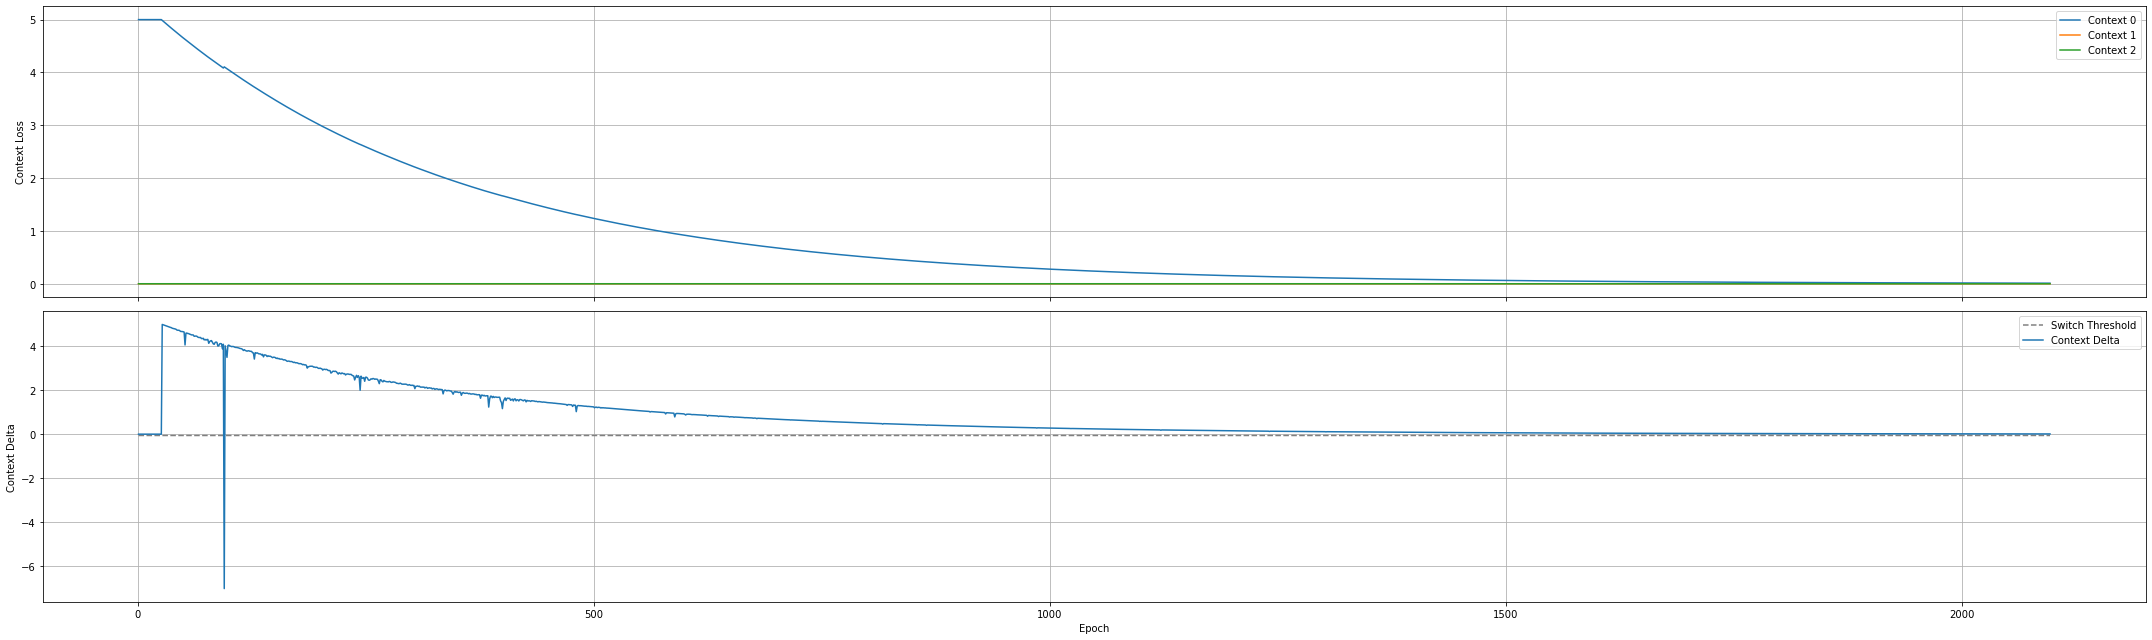

In [143]:
logger.plot()

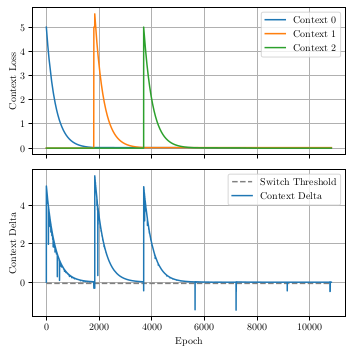

In [160]:
l.plot(figsize=(5,5), savefile="graphs/maze_static.pgf")

## Analysis & Results

In [122]:
# Load the model results
with open("data/maze_analysis8.dat", 'rb') as f:
    data = pickle.load(f)

In [123]:
data.keys()

dict_keys([(3, 3), (6, 3), (1, 3), (0, 3), (9, 3), (8, 3), (2, 3), (4, 3), (7, 3), (5, 3), (11, 3), (12, 3), (10, 3), (14, 3), (15, 3), (17, 3), (13, 3), (18, 3), (16, 3), (19, 3)])

In [126]:
l = ContextLogger()
key = (1, 3)
l.plots = data[key][0]

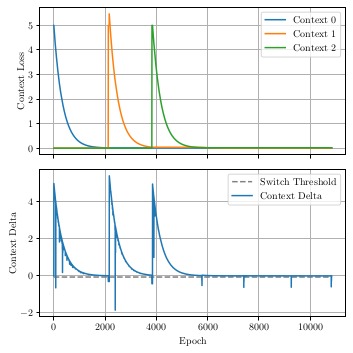

In [127]:
l.plot(figsize=(5,5))

In [128]:
data[key].keys()

AttributeError: 'list' object has no attribute 'keys'

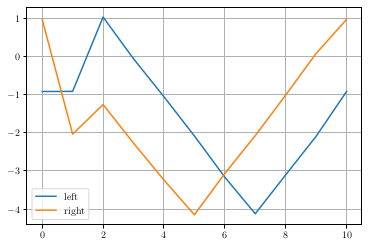

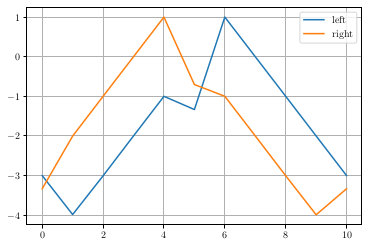

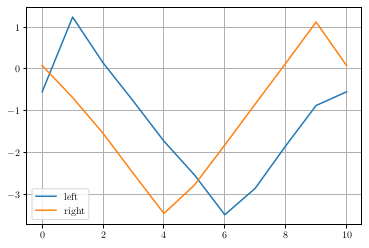

In [121]:
for c in range(3):
    plot_q_function(data[key][2][2500][c])

In [46]:
suboptimal_moves(data[key][2][0][0], 0, 10)

4

In [94]:
goals = (0, 1, 5)
maze_size = 10
subopt_moves = 100.0*np.array([
    np.array([np.max([
        np.mean([1.0-suboptimal_moves(data[key][2][episode][i], goals[c[i]], maze_size)/(maze_size-1) for i in range(3)]) for c in itertools.permutations(range(3))
    ]) for episode in range(3010)])
for key in data])

In [95]:
subopt_moves[:,-1]

array([100.        , 100.        , 100.        , 100.        ,
       100.        , 100.        , 100.        , 100.        ,
        74.07407407, 100.        , 100.        , 100.        ,
       100.        , 100.        , 100.        , 100.        ,
       100.        , 100.        , 100.        , 100.        ,
       100.        , 100.        , 100.        , 100.        ,
       100.        , 100.        , 100.        , 100.        ,
        62.96296296, 100.        ])

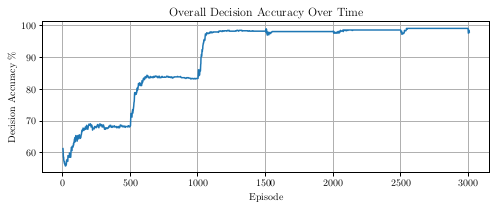

In [96]:
mpl.use("pgf")
mpl.rcParams.update({
                "pgf.texsystem": "pdflatex",
                "font.family": "serif",
                "text.usetex": True,
                "pgf.rcfonts": False
            })
fig, ax = plt.subplots(figsize=(7,3))
x, y = np.arange(subopt_moves.shape[1]), np.mean(subopt_moves[:3000], axis=0)
ax.plot(x, y)
# ax.fill_between(x, (y-ci), (y+ci), color='b', alpha=.1)
ax.set_xlabel("Episode")
ax.set_ylabel("Decision Accuracy %")
ax.set_title("Overall Decision Accuracy Over Time")
ax.grid()
# ax.legend()
fig.tight_layout()
# fig.savefig("graphs/maze_accuracy.pgf")

{'whiskers': [<matplotlib.lines.Line2D at 0x7f351b42edc0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f352602e3a0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f3525f0f550>,
 'medians': [<matplotlib.lines.Line2D at 0x7f352567dbe0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f352567d130>,
 'means': []}

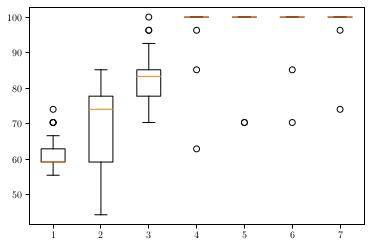

In [97]:
plt.boxplot(subopt_moves[:,::500])

In [438]:
a = np.arange(10)
a

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [442]:
a[::2]

array([0, 2, 4, 6, 8])

1 Outlier kinda messes up any good loss plot that could be generated... With enough models trained this could resolve the issues...

In [401]:
goals = (0, 1, 5)
optimal = np.array([optimal_q_function(10, goal) for goal in goals])
losses = np.array([
    np.array([np.min([
        np.mean([q_loss(data[key][2][episode][i], optimal[c[i]], goals[c[i]]) for i in range(3)]) for c in itertools.permutations(range(3))
    ]) for episode in range(3010)])
for key in data])

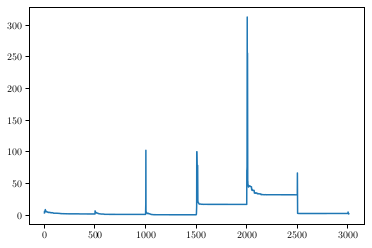

In [402]:
plt.plot(np.mean(losses, axis=0))

Now, determine if there are any seeds that result in guaranteed solution by comparing the deltas upon switching.

In [241]:
possible = []
for key in sorted(data.keys()):
    maze = data[key]
    delta_switches = { k: v[1] for k, v in maze[1].items()}
    delta_keys = np.array(list(delta_switches.keys()))
    main_deltas = np.array(list(delta_switches.values()))
    other_deltas = np.array(get_deltas(maze[0]))
    max_delta = np.max(main_deltas)
    bad = False
    for i, delta in enumerate(other_deltas):
        # I'm a bit lazy here... Make sure the episode does not fall under a delayed switch before checking the deltas
        if maze[4][0] <= i <= maze[4][250] or maze[4][501] <= i <= maze[4][750] or maze[4][1001] <= i <= maze[4][1250]:
            continue
        if (i in delta_keys and delta > max_delta):
            print(key, "Did not trigger at step", i, delta)
            bad = True
            break
        elif (i not in delta_keys and delta <= max_delta):
            print(key, "Triggered unexpectedly at step", i, delta)
            bad = True
            break
    if not bad:
        possible.append(key)
print(f"{len(possible)}/{len(data)}", '\n', possible)

(7, 3) Triggered unexpectedly at step 7824 -0.09754372388124466
0/1 
 []


In [201]:
deltas = {}
for key in sorted(data.keys()):
    deltas[key] = np.max(np.array([v[1] for v in data[key][1].values()]))

ValueError: zero-size array to reduction operation maximum which has no identity

In [74]:
deltas

{(0, 3): -0.2736501,
 (1, 3): -0.034507595,
 (2, 3): -0.06769254,
 (3, 3): -0.061026827,
 (4, 3): -0.38358998,
 (5, 3): 0.0058543794,
 (6, 3): -0.30880067,
 (7, 3): -0.018820884,
 (8, 3): -0.285042,
 (9, 3): -0.0447234}

In [154]:
threshold = -0.034
threshold = -0.06
keys = []
for key in sorted(data.keys()):
    maze = data[key]
    delta_switches = { k: v[1] for k, v in maze[1].items()}
    delta_keys = np.array(list(delta_switches.keys()))
    main_deltas = np.array(list(delta_switches.values()))
    other_deltas = np.array(get_deltas(maze[0]))
    max_delta = np.max(main_deltas)
    bad = False
    for i, delta in enumerate(other_deltas):
        # I'm a bit lazy here... Make sure the episode does not fall under a delayed switch before checking the deltas
        if maze[4][0] <= i <= maze[4][250] or maze[4][501] <= i <= maze[4][750] or maze[4][1001] <= i <= maze[4][1250]:
            continue
        if (i in delta_keys and delta > threshold):
            print(key, "Did not trigger at step", i, delta)
            bad = True
            break
        elif (i not in delta_keys and delta <= threshold):
            print(key, "Triggered unexpectedly at step", i, delta)
            bad = True
            break
    if not bad:
        keys.append(key)
print(f"{len(keys)}/{len(data)}", '\n', keys)

1/1 
 [(6, 3)]


In [77]:
deltas[(512, False)]

KeyError: (512, False)

In [27]:
for seed in range(1):
    for use_bias in (False,):
        key = (seed, 3, 512, use_bias)
        goal = goals[data[key][3][0]]
        opt_v = optimal_v_function(10, goal, 1.0)
        plot_q_function(data[key][2][300], title=str(goal) + ' ' + str(key) + ' ' + str(v_loss(v_function(data[key][2][300]), opt_v)))

NameError: name 'goals' is not defined

In [621]:
data.keys()

dict_keys([(0, 3, 1024, False), (0, 3, 512, True), (0, 3, 512, False), (0, 3, 1024, True), (1, 3, 1024, False), (1, 3, 512, True), (1, 3, 512, False), (1, 3, 1024, True), (2, 3, 512, False), (2, 3, 1024, False), (2, 3, 512, True), (2, 3, 1024, True), (3, 3, 512, False), (3, 3, 512, True), (3, 3, 1024, False), (3, 3, 1024, True), (4, 3, 512, False), (4, 3, 512, True), (4, 3, 1024, False), (4, 3, 1024, True), (5, 3, 512, False), (5, 3, 512, True), (5, 3, 1024, False), (5, 3, 1024, True), (6, 3, 1024, False), (6, 3, 512, False), (7, 3, 512, False), (6, 3, 512, True), (6, 3, 1024, True), (7, 3, 512, True), (7, 3, 1024, False), (8, 3, 512, False), (8, 3, 512, True), (8, 3, 1024, False), (7, 3, 1024, True), (9, 3, 512, False), (8, 3, 1024, True), (9, 3, 512, True), (9, 3, 1024, False), (9, 3, 1024, True)])

In [ ]:
for key in sorted(data.keys()):
    plot_q_function(data[key][2][300], title=str(key))